### Step 1: Import Datasets and merge

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load macroeconomic and forex datasets
macro = pd.read_csv("macro_data.csv", parse_dates=["DATE"]).set_index("DATE")
forex = pd.read_csv("forex_merged_cleaned.csv", parse_dates=["DATE"]).set_index("DATE")

In [3]:
print("Macro Data:")
print(macro.head(25))

print("\nForex Data:")
print(forex.head(25))

Macro Data:
            Trade Balance  Inflation (CPI)  Core Inflation  Interest Rate  \
DATE                                                                        
2002-01-01       -29678.0            177.7           188.7           1.73   
2002-02-01       -32501.0            178.0           189.1           1.74   
2002-03-01       -31161.0            178.5           189.2           1.73   
2002-04-01       -33965.0            179.3           189.7           1.75   
2002-05-01       -34026.0            179.5           190.0           1.75   
2002-06-01       -34732.0            179.6           190.2           1.75   
2002-07-01       -33913.0            180.0           190.5           1.73   
2002-08-01       -36385.0            180.5           191.1           1.74   
2002-09-01       -36088.0            180.8           191.3           1.75   
2002-10-01       -35095.0            181.2           191.5           1.75   
2002-11-01       -39515.0            181.5           191.9      

In [10]:
# Convert exchange rates to log returns
log_returns = np.log(forex / forex.shift(1))
log_returns = log_returns.dropna()
log_returns.columns = [col + " Return" for col in log_returns.columns]

In [17]:
# Align and merge macro with log returns on DATE
full_df = pd.merge(macro, log_returns, left_index=True, right_index=True, how='inner')
# Drop rows with any missing data (can customize later)
full_df = full_df.dropna()
full_df.head()

,Trade Balance,Inflation (CPI),Core Inflation,Interest Rate,Industrial Production,Retail Sales,Consumer Sentiment,Unemployment Rate,Manufacturing PMI,S&P 500 Index,...,USD-AUD Return,USD-CAD Return,USD-CHF Return,USD-CNY Return,USD-EUR Return,USD-GBP Return,USD-HKD Return,USD-JPY Return,USD-NZD Return,USD-XAU Return
DATE,,,,,,,,,,,,,,,,,,,,,
2002-03-01,-31161.0,178.5,189.2,1.73,89.1265,284262.0,95.7,5.7,50.7,1106.73,...,-0.020278,0.007835,-0.013291,-0.000012,-0.011569,-0.004667,0.000013,-0.009849,-0.013128,-0.046385
2002-04-01,-33965.0,179.3,189.7,1.75,89.5507,288833.0,93.0,5.9,52.4,1147.39,...,-0.027978,-0.004192,-0.009059,0.000109,-0.002642,-0.005979,0.000051,-0.004735,-0.043389,-0.020990
2002-05-01,-34026.0,179.5,190.0,1.75,89.9348,284951.0,96.9,5.8,52.4,1076.92,...,-0.010270,-0.017201,-0.038686,-0.000012,-0.032505,-0.022262,-0.000090,-0.032077,-0.015546,-0.018349
2002-06-01,-34732.0,179.6,190.2,1.75,90.6736,287372.0,92.4,5.8,53.1,1067.14,...,-0.052648,-0.025715,-0.031208,-0.000097,-0.036740,0.001854,0.000090,-0.034186,-0.071806,-0.057158
2002-07-01,-33913.0,180.0,190.5,1.73,90.6436,290385.0,88.1,5.8,53.6,989.81,...,0.007075,-0.006896,-0.056956,0.000072,-0.059528,-0.052341,-0.000051,-0.038989,-0.013434,0.038466


### Step 2: Run OLS Regression per Currency

In [21]:
import statsmodels.api as sm

# 1. Identify columns
macro_vars = macro.columns.tolist()
fx_targets = [col for col in full_df.columns if "Return" in col]

# 2. Store results
results = []

# 3. Loop through each currency return and run OLS
for target in fx_targets:
    X = full_df[macro_vars]
    y = full_df[target]
    
    # Add intercept
    X_const = sm.add_constant(X)
    
    # Fit OLS model
    model = sm.OLS(y, X_const).fit()
    
    # Store results
    results.append({
        "Currency": target.replace(" Return", ""),
        "R_squared": model.rsquared,
        "Adj_R_squared": model.rsquared_adj,
        "Coefficients": model.params.to_dict(),
        "P_values": model.pvalues.to_dict()
    })

In [31]:
# Flatten into a readable summary table
summary = pd.DataFrame({
    "Currency": [res["Currency"] for res in results],
    "R_squared": [res["R_squared"] for res in results],
    "Adj_R_squared": [res["Adj_R_squared"] for res in results]
})

summary.sort_values("R_squared", ascending=False, inplace=True)
summary.head(10)

,Currency,R_squared,Adj_R_squared
0,USD-AUD,0.211995,0.179161
8,USD-NZD,0.190837,0.157121
1,USD-CAD,0.173453,0.139014
5,USD-GBP,0.140995,0.105203
4,USD-EUR,0.104982,0.067689
7,USD-JPY,0.086948,0.048904
3,USD-CNY,0.076104,0.037608
2,USD-CHF,0.070586,0.031860
9,USD-XAU,0.058102,0.018856
6,USD-HKD,0.036166,-0.003994


In [39]:
# Create a DataFrame with currencies as rows and macro variables as columns
coeff_matrix = pd.DataFrame()

# Loop through results and pull each currency's coefficients
for res in results:
    currency = res["Currency"]
    coeffs = res["Coefficients"]
    
    # Convert to Series and name it with the currency
    coeff_series = pd.Series(coeffs, name=currency)
    
    # Append as a new row to the matrix
    coeff_matrix = pd.concat([coeff_matrix, coeff_series.to_frame().T], axis=0)

# Set currency names as the index
coeff_matrix.index.name = "Currency"

# Drop the constant (intercept) column if you only want macro variable effects
coeff_matrix = coeff_matrix.drop(columns="const", errors='ignore')

pd.set_option('display.float_format', '{:.9f}'.format)
coeff_matrix.head(10)

,Trade Balance,Inflation (CPI),Core Inflation,Interest Rate,Industrial Production,Retail Sales,Consumer Sentiment,Unemployment Rate,Manufacturing PMI,S&P 500 Index,VIX Index
Currency,,,,,,,,,,,
USD-AUD,-0.000000249,0.006025727,-0.005484707,0.000599187,-0.000422744,-0.000000109,0.001723048,-0.004336749,0.000503811,0.000000479,0.002766078
USD-CAD,-0.000000199,0.002020702,-0.001500754,-0.000165796,0.001123213,-0.000000144,0.000700578,-0.001222078,0.000114279,-0.000000634,0.001703703
USD-CHF,-0.000000414,0.002974896,-0.002984984,-0.000803831,-0.000707860,0.000000127,0.001171354,-0.000521073,-0.000196270,-0.000008066,0.001062488
USD-CNY,-0.000000026,0.000315574,-0.000237144,-0.000189358,-0.000532364,0.000000065,0.000217461,-0.001201075,0.000005027,-0.000006502,0.000235927
USD-EUR,-0.000000261,0.003144222,-0.002880174,-0.000864770,-0.000236976,-0.000000019,0.000876409,-0.001417752,0.000284979,-0.000002341,0.001302293
USD-GBP,-0.000000616,0.001721159,-0.001040305,-0.002424515,-0.000029768,-0.000000096,0.000614166,-0.003079519,-0.000268299,-0.000012180,0.001171903
USD-HKD,-0.000000013,-0.000019881,0.000012239,-0.000090273,-0.000020606,0.000000009,0.000000931,-0.000084403,0.000032039,-0.000000701,-0.000005488
USD-JPY,-0.000000222,0.002078786,-0.002745991,-0.001640448,-0.000873885,0.000000337,0.000651699,0.001269367,-0.000577126,-0.000007766,-0.000296356
USD-NZD,-0.000000345,0.005211314,-0.004893475,0.000470543,0.000003592,-0.000000005,0.001580889,-0.003349771,0.000251844,-0.000004315,0.002770340


### STEP 3: Train a Predictive Model (Lasso)

In [45]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [47]:
# Define train/test split
train_end = "2022-12-31"

# Training set: data until end of 2022
train_df = full_df.loc[:train_end]

# Test set: data from 2023 onward
test_df = full_df.loc["2023-01-01":]

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (250, 21)
Test shape: (26, 21)


In [49]:
# Macro variables (predictors) and currency returns (targets)
macro_vars = macro.columns.tolist()
fx_targets = [col for col in full_df.columns if "Return" in col]

# Define X and Y for train and test
X_train = train_df[macro_vars]
X_test = test_df[macro_vars]

In [63]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

lasso_results = []

for target in fx_targets:
    y_train = train_df[target]
    y_test = test_df[target]
    
    lasso = Lasso(alpha=0.001, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    lasso_results.append({
        "Currency": target.replace(" Return", ""),
        "RMSE": rmse,
        "MAE": mae,
        "Model": lasso,
        "y_test": y_test,
        "y_pred": y_pred
    })

In [65]:
# Create a summary DataFrame
lasso_summary = pd.DataFrame({
    "Currency": [res["Currency"] for res in lasso_results],
    "RMSE": [res["RMSE"] for res in lasso_results],
    "MAE": [res["MAE"] for res in lasso_results]
})

# Sort by RMSE (lower = better)
lasso_summary = lasso_summary.sort_values("RMSE")
print(lasso_summary.head(10))

  Currency        RMSE         MAE
6  USD-HKD 0.002218376 0.001651117
3  USD-CNY 0.017067047 0.013962735
5  USD-GBP 0.024442667 0.020550028
4  USD-EUR 0.028950342 0.025143456
2  USD-CHF 0.030000270 0.026497654
1  USD-CAD 0.031867874 0.028210160
7  USD-JPY 0.034222727 0.027538554
9  USD-XAU 0.041413054 0.034633293
0  USD-AUD 0.048352722 0.042513633
8  USD-NZD 0.050873579 0.043587176


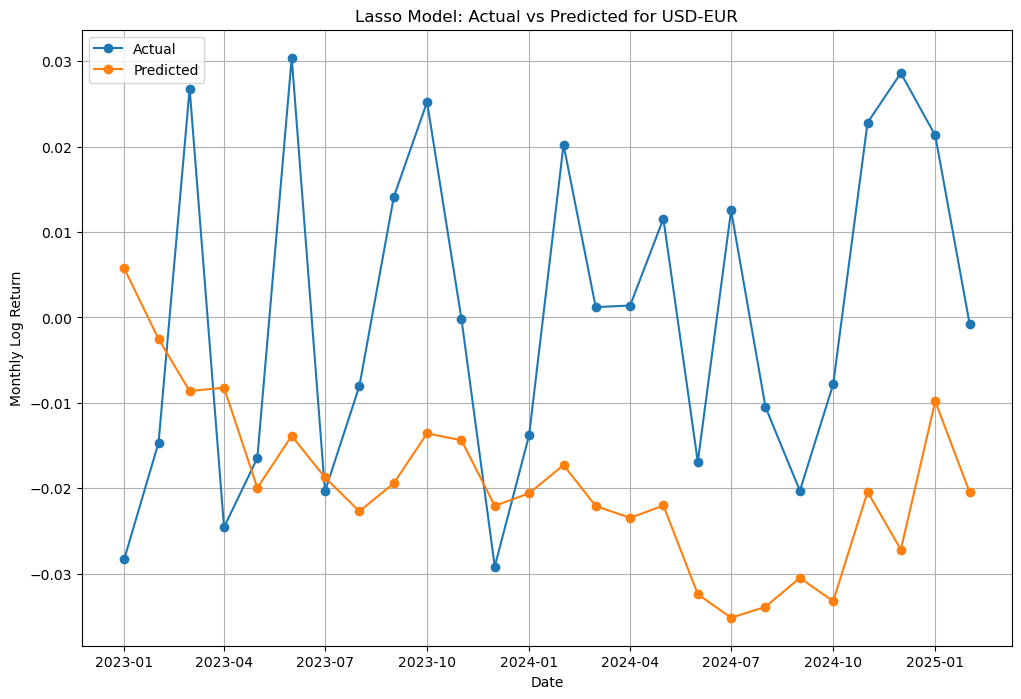

In [99]:
# Example: Plot for one currency (e.g., USD-EUR)
currency_to_plot = "USD-EUR"

for res in lasso_results:
    if res["Currency"] == currency_to_plot:
        plt.figure(figsize=(12,8))
        plt.plot(res["y_test"].index, res["y_test"], label="Actual", marker='o')
        plt.plot(res["y_test"].index, res["y_pred"], label="Predicted", marker='o')
        plt.title(f"Lasso Model: Actual vs Predicted for {currency_to_plot}")
        plt.xlabel("Date")
        plt.ylabel("Monthly Log Return")
        plt.legend()
        plt.grid(True)
        plt.show()
        break

### STEP 4: Train a Predictive Model (XGBoost)

In [85]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [87]:
# Inputs and outputs
macro_vars = macro.columns.tolist()
fx_targets = [col for col in full_df.columns if "Return" in col]

X_train = train_df[macro_vars]
X_test = test_df[macro_vars]

In [89]:
xgb_results = []

for target in fx_targets:
    y_train = train_df[target]
    y_test = test_df[target]
    
    # Initialize XGBoost model
    xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
    
    # Fit the model
    xgb.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = xgb.predict(X_test)
    
    # Evaluate
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    xgb_results.append({
        "Currency": target.replace(" Return", ""),
        "RMSE": rmse,
        "MAE": mae,
        "Model": xgb,
        "y_test": y_test,
        "y_pred": y_pred
    })

In [91]:
# Create summary table
xgb_summary = pd.DataFrame({
    "Currency": [res["Currency"] for res in xgb_results],
    "RMSE": [res["RMSE"] for res in xgb_results],
    "MAE": [res["MAE"] for res in xgb_results]
})

xgb_summary = xgb_summary.sort_values("RMSE")
print(xgb_summary.head(10))

  Currency        RMSE         MAE
6  USD-HKD 0.003131054 0.002451948
3  USD-CNY 0.016471343 0.013810122
4  USD-EUR 0.018923726 0.016097399
1  USD-CAD 0.026364130 0.022800041
2  USD-CHF 0.031863736 0.025917622
5  USD-GBP 0.032846626 0.027404873
0  USD-AUD 0.039180523 0.031776830
9  USD-XAU 0.040072189 0.030801682
7  USD-JPY 0.042189592 0.034091983
8  USD-NZD 0.048698491 0.042487060


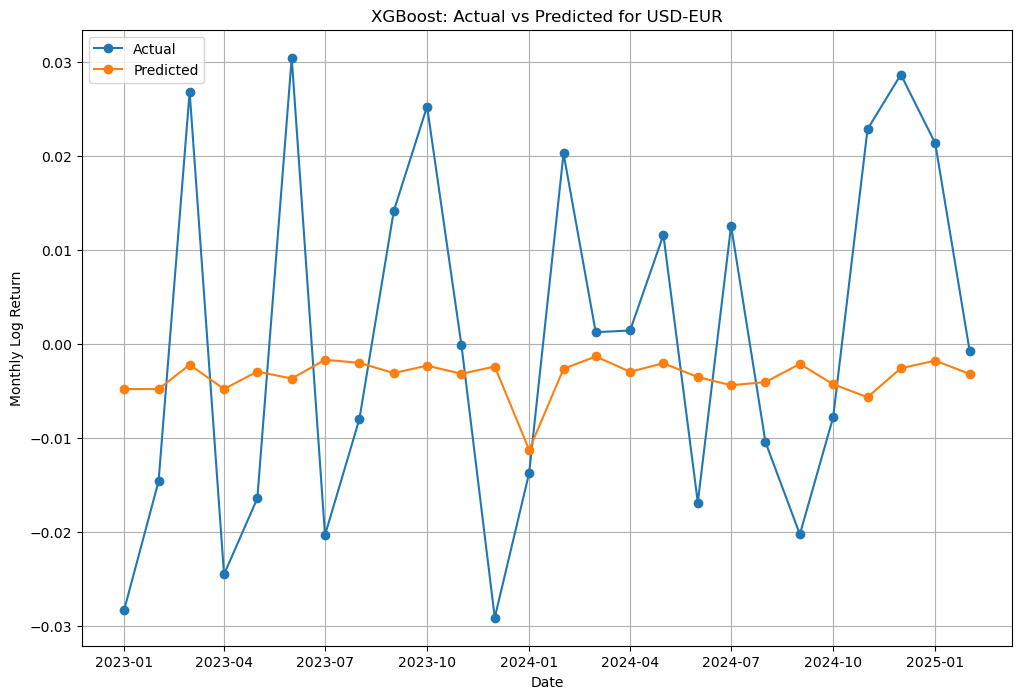

In [97]:
import matplotlib.pyplot as plt

currency_to_plot = "USD-EUR"

for res in xgb_results:
    if res["Currency"] == currency_to_plot:
        plt.figure(figsize=(12,8))
        plt.plot(res["y_test"].index, res["y_test"], label="Actual", marker='o')
        plt.plot(res["y_test"].index, res["y_pred"], label="Predicted", marker='o')
        plt.title(f"XGBoost: Actual vs Predicted for {currency_to_plot}")
        plt.xlabel("Date")
        plt.ylabel("Monthly Log Return")
        plt.legend()
        plt.grid(True)
        plt.show()
        break